# Classifiers

In order to run this notebook you must have installed some packages.  See [requirements](requirements.txt).  
File produced by running `conda list --export > requirements.txt`


Reference: 
* [Multi-Label Text Classification by Zuzanna Deutschman](https://towardsdatascience.com/multi-label-text-classification-5c505fdedca8).
* [Multi-label Classification Examples](https://skml.readthedocs.io/en/latest/auto_examples/index.html)

## Setting up libraries

### Importing py modules

In [82]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
# import nltk
# nltk.download('stopwords')

# from nltk.corpus import stopwords
# from nltk.stem.snowball import SnowballStemmer
# from bs4 import BeautifulSoup
# import lxml

import re
# import csv
# from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import BernoulliNB
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix
# from sklearn.preprocessing import MultiLabelBinarizer
# import pickle


## Loading the data

In [83]:
tweets_new = pd.read_csv('tweets.csv')
# tweets_new

In [84]:
tweets = tweets_new.copy()
tweets.head(10)

,text_y,circumstantial-information,electricity,gas,gasoline,social-report,twitter-account,water
0,#1abr en foto la fuerte cola que se re...,2,0,0,2,1,0,0
1,#22nov #guayana alta vista los olivos ...,2,1,0,0,0,0,0
2,#28dic #singasolina #ciudadguayana deberi...,4,0,0,1,2,0,0
3,#ahora estaciones esperando por la cister...,4,0,0,2,0,0,0
4,#carabobo #singasolina imposible salir en ...,1,0,0,1,1,0,0
5,#denuncia en varias parroquias del oeste ...,1,0,0,2,3,0,0
6,#singasolina@dmurolo la cola llega al km1...,1,0,0,2,1,0,0
7,#sinluz #lacabagna #laboyera #elhatillo @e...,2,1,0,0,0,0,0
8,#sinluz esta usted y su falla debe ser ...,0,2,0,0,2,0,0
9,#sinluz los caobos sabana grande la ...,2,1,0,0,0,0,0


In [85]:
# print(tweets.columns.values)

# get the name of the columns: text and labels
TEXT_DESCRIPTION_COL = tweets.columns.values[0]
CIRCUMSTANTIAL_DESCRIPTION_COL = tweets.columns.values[1]
ELECTRICITY_DESCRIPTION_COL = tweets.columns.values[2]
GAS_DESCRIPTION_COL = tweets.columns.values[3]
GASOLINE_DESCRIPTION_COL = tweets.columns.values[4]
SOCIAL_DESCRIPTION_COL = tweets.columns.values[5]
ACCOUNT_DESCRIPTION_COL = tweets.columns.values[6]
WATER_DESCRIPTION_COL = tweets.columns.values[7]
print('Column names:')
print('\t' ,TEXT_DESCRIPTION_COL)
print('\t' ,CIRCUMSTANTIAL_DESCRIPTION_COL)
print('\t' ,ELECTRICITY_DESCRIPTION_COL)
print('\t' ,GAS_DESCRIPTION_COL)
print('\t' ,GASOLINE_DESCRIPTION_COL)
print('\t' ,SOCIAL_DESCRIPTION_COL)
print('\t' ,ACCOUNT_DESCRIPTION_COL)
print('\t' ,WATER_DESCRIPTION_COL)

Column names:
	 text_y
	 circumstantial-information
	 electricity
	 gas
	 gasoline
	 social-report
	 twitter-account
	 water


In [86]:
tc = tweets.copy()

# isolate the text and the labels
tc_labels = tc.drop(labels=[TEXT_DESCRIPTION_COL], axis=1)
tc_text = tc.drop(labels=[CIRCUMSTANTIAL_DESCRIPTION_COL,
                          ELECTRICITY_DESCRIPTION_COL, GAS_DESCRIPTION_COL,
                          GASOLINE_DESCRIPTION_COL, SOCIAL_DESCRIPTION_COL,
                          ACCOUNT_DESCRIPTION_COL, WATER_DESCRIPTION_COL], axis=1)

# replaces any number greater than 0 for a 1, bc we need "existance" or "not existance" of the
# label on the tweet
tc_labels = tc_labels.where(tc_labels == 0, 1)
tc_labels.head(10)

,circumstantial-information,electricity,gas,gasoline,social-report,twitter-account,water
0,1,0,0,1,1,0,0
1,1,1,0,0,0,0,0
2,1,0,0,1,1,0,0
3,1,0,0,1,0,0,0
4,1,0,0,1,1,0,0
5,1,0,0,1,1,0,0
6,1,0,0,1,1,0,0
7,1,1,0,0,0,0,0
8,0,1,0,0,1,0,0
9,1,1,0,0,0,0,0


In [87]:
binarized_tweet_labels = tc_text.merge(tc_labels, on=tc_labels.index)  # in case I need to merge them
binarized_tweet_labels = binarized_tweet_labels.drop(labels = ['key_0'], axis=1)
binarized_tweet_labels.head(10)

,text_y,circumstantial-information,electricity,gas,gasoline,social-report,twitter-account,water
0,#1abr en foto la fuerte cola que se re...,1,0,0,1,1,0,0
1,#22nov #guayana alta vista los olivos ...,1,1,0,0,0,0,0
2,#28dic #singasolina #ciudadguayana deberi...,1,0,0,1,1,0,0
3,#ahora estaciones esperando por la cister...,1,0,0,1,0,0,0
4,#carabobo #singasolina imposible salir en ...,1,0,0,1,1,0,0
5,#denuncia en varias parroquias del oeste ...,1,0,0,1,1,0,0
6,#singasolina@dmurolo la cola llega al km1...,1,0,0,1,1,0,0
7,#sinluz #lacabagna #laboyera #elhatillo @e...,1,1,0,0,0,0,0
8,#sinluz esta usted y su falla debe ser ...,0,1,0,0,1,0,0
9,#sinluz los caobos sabana grande la ...,1,1,0,0,0,0,0


## Vectorizing

In [88]:
# spliting the data into train and test
train, test = train_test_split(binarized_tweet_labels, random_state=21, test_size=0.30, shuffle=True)
train_text = train[TEXT_DESCRIPTION_COL].values.astype('U')
test_text = test[TEXT_DESCRIPTION_COL].values.astype('U')


# creating the vectorizer, using uni-bi-tri grams, and selecting only 10000 features.
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', 
                             ngram_range=(1,3), norm='l2', max_features = 10000)

vectorizer.fit(train_text)
vectorizer.fit(test_text)

# x_train is the vectorization of each document - sparse matrix
x_train = vectorizer.transform(train_text)

# y_train are the corresponding labels of each document - pandas.DF
y_train = train.drop(labels = [TEXT_DESCRIPTION_COL], axis=1)

# same as above, but whit will be used for testing
x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = [TEXT_DESCRIPTION_COL], axis=1)


In [89]:
x_train

<28x466 sparse matrix of type '<class 'numpy.float64'>'
	with 228 stored elements in Compressed Sparse Row format>

#### Explore . . .

In [90]:
# features selected by the vectorizer with uni-bi-tri grams
# x_train
features = vectorizer.get_feature_names()
features

['00',
 '00 am',
 '15',
 '15 horas',
 '15 horas sinluz',
 '19',
 '19 dias',
 '19 dias sinagua',
 '20',
 '20 horas',
 '20 horas sinluz',
 '20s',
 '22nov',
 '22nov guayana',
 '22nov guayana alta',
 '30',
 '30 litros',
 '30 litros puede',
 '4pm',
 '4pm el',
 '4pm el tanque',
 '840pm',
 '840pm sinluz',
 '840pm sinluz en',
 'agoniza',
 'agoniza la',
 'agoniza la mal',
 'al',
 'al retornar',
 'al retornar con',
 'algo',
 'algo caliente',
 'alianza',
 'alianza villa',
 'alianza villa brasil',
 'almuerzo',
 'almuerzo decente',
 'almuerzo decente al',
 'alrededor',
 'alrededor de',
 'alrededor de las',
 'alta',
 'alta vista',
 'alta vista los',
 'am',
 'asia',
 'asia villa',
 'asia villa alianza',
 'atentos',
 'atentos sus',
 'atentos sus gestiones',
 'brasil',
 'brasil sinluz',
 'buenas',
 'buenas tardes',
 'buenas tardes corpoelecinfo',
 'caliente',
 'calor',
 'calor es',
 'calor es insoportable',
 'caracas',
 'caracas seguimos',
 'caracas seguimos sinluz',
 'castillito',
 'castillito villa',

## Build a model, train and predict

Helper methods to evaluate the model

In [91]:
def report_measures(y_test, y_pred) -> None:

    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Hamming loss: ", hamming_loss(y_test, y_pred))
    
    print("F1 score:")
    print("\tmicro: ", f1_score(y_test, y_pred, average='micro'))
    print("\tmacro: ", f1_score(y_test, y_pred, average='macro'))

    print("Precision:")
    print("\tmicro: ", precision_score(y_test, y_pred, average='micro'))
    print("\tmacro: ", precision_score(y_test, y_pred, average='macro'))

    print("Recall:")
    print("\tmicro: ", recall_score(y_test, y_pred, average='micro'))
    print("\tmacro: ", recall_score(y_test, y_pred, average='macro'))


### Binary Relevance
1. with GaussianNB

In [92]:
#Binary Relevance: Naive Bayes with Bernoulli Distribution
br_classifier = BinaryRelevance(BernoulliNB())
br_classifier.fit(x_train, y_train)
br_predictions = br_classifier.predict(x_test)

report_measures(y_test, br_predictions)

Accuracy:  0.0
Hamming loss:  0.39285714285714285
F1 score:
	micro:  0.5074626865671641
	macro:  0.3486215538847118
Precision:
	micro:  0.4857142857142857
	macro:  0.3596938775510204
Recall:
	micro:  0.53125
	macro:  0.48852813852813853


2. with LogisticRegression

In [93]:
# Binary Relevance: Logistic Regression
br_classifier1 = BinaryRelevance(LogisticRegression())
br_classifier1.fit(x_train, y_train)
br_predictions1 = br_classifier1.predict(x_test)

report_measures(y_test, br_predictions1)

# br_predictions.toarray()
# y_test

Accuracy:  0.08333333333333333
Hamming loss:  0.20238095238095238
F1 score:
	micro:  0.7733333333333334
	macro:  0.39925100474972597
Precision:
	micro:  0.6744186046511628
	macro:  0.3537414965986394
Recall:
	micro:  0.90625
	macro:  0.5714285714285714


/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Label Powerset


In [94]:
#Label Powerset
lp_classifier = LabelPowerset(LogisticRegression())
lp_classifier.fit(x_train, y_train)
lp_predictions = lp_classifier.predict(x_test)

report_measures(y_test, lp_predictions)

Accuracy:  0.0
Hamming loss:  0.40476190476190477
F1 score:
	micro:  0.4999999999999999
	macro:  0.24265759815631943
Precision:
	micro:  0.4722222222222222
	macro:  0.20238095238095238
Recall:
	micro:  0.53125
	macro:  0.42857142857142855


/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### MLkNN

In [95]:
ml_classifier = MLkNN(k=4)
# to prevent errors when handling sparse matrices.
x_train = lil_matrix(x_train).toarray()
y_train = lil_matrix(y_train).toarray()
x_test = lil_matrix(x_test).toarray()

ml_classifier.fit(x_train, y_train)
ml_predictions = ml_classifier.predict(x_test)

report_measures(y_test, ml_predictions)

Accuracy:  0.16666666666666666
Hamming loss:  0.23809523809523808
F1 score:
	micro:  0.7142857142857143
	macro:  0.38103371783496004
Precision:
	micro:  0.6578947368421053
	macro:  0.3625541125541125
Recall:
	micro:  0.78125
	macro:  0.5238095238095238


/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass n_neighbors=4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Classifier Chain Model

In [96]:
# for the next classifier we need to remove from y-train, y-test categories which
# equal 0 for all train samples
# y_train = train.drop(labels = [TEXT_DESCRIPTION_COL], axis=1)
# y_test = test.drop(labels = [TEXT_DESCRIPTION_COL], axis=1)
# selected_labels = y_train.columns[y_train.sum(axis = 0, skipna = True) > 0].tolist()

# y_train = y_train.filter(selected_labels, axis=1)
# y_test = y_test.filter(selected_labels, axis=1)
# x_train = vectorizer.transform(train_text)
# x_test = vectorizer.transform(test_text)

cc_classifier = ClassifierChain(LogisticRegression())
cc_classifier.fit(x_train, y_train)
cc_predictions_proba = cc_classifier.predict_proba(x_test)

# report_measures(y_test, cc_predictions_proba)

t = 0.05 	 Accuracy =  0.0 	 F1 =  0.5904761904761905 	 Hamming loss =  0.5119047619047619
t = 0.06 	 Accuracy =  0.0 	 F1 =  0.5961538461538461 	 Hamming loss =  0.5
t = 0.07 	 Accuracy =  0.0 	 F1 =  0.5961538461538461 	 Hamming loss =  0.5
t = 0.08 	 Accuracy =  0.0 	 F1 =  0.5961538461538461 	 Hamming loss =  0.5
t = 0.09 	 Accuracy =  0.0 	 F1 =  0.5961538461538461 	 Hamming loss =  0.5
t = 0.1 	 Accuracy =  0.0 	 F1 =  0.6019417475728155 	 Hamming loss =  0.4880952380952381
t = 0.11 	 Accuracy =  0.0 	 F1 =  0.6391752577319587 	 Hamming loss =  0.4166666666666667
t = 0.12 	 Accuracy =  0.08333333333333333 	 F1 =  0.6896551724137931 	 Hamming loss =  0.32142857142857145
t = 0.13 	 Accuracy =  0.08333333333333333 	 F1 =  0.6987951807228915 	 Hamming loss =  0.2976190476190476
t = 0.14 	 Accuracy =  0.08333333333333333 	 F1 =  0.7160493827160493 	 Hamming loss =  0.27380952380952384
t = 0.15 	 Accuracy =  0.08333333333333333 	 F1 =  0.725 	 Hamming loss =  0.2619047619047619
t = 0.1

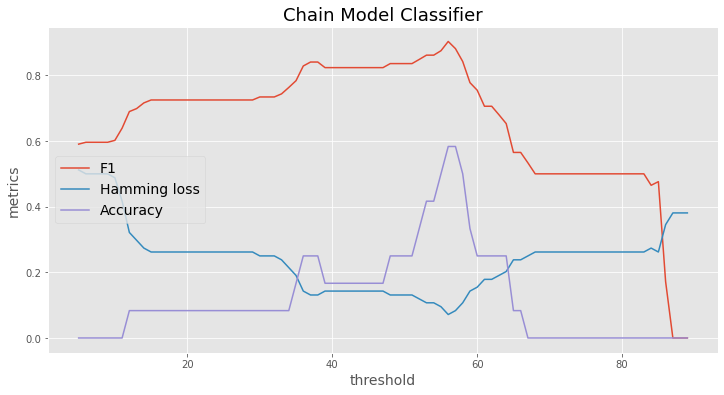

In [97]:
#for plotting metrics as a function of threashold
def plotting_metrics_function_of_threshold(model_name, cc_predictions_proba, y_test):
    th = []
    f = []
    ham = []
    ac = []

    for t in range (5,90): # threshold value
        y_pred_new = (cc_predictions_proba >= t/100).astype(int)
        print("t =" ,t/100, '\t', "Accuracy = ",accuracy_score(y_test,y_pred_new),
             '\t', "F1 = ",f1_score(y_test,y_pred_new, average="micro"), '\t',
              "Hamming loss = ",hamming_loss(y_test,y_pred_new))
        th.append(t)
        ac.append(accuracy_score(y_test,y_pred_new))
        f.append(f1_score(y_test,y_pred_new, average="micro"))
        ham.append(hamming_loss(y_test,y_pred_new))
    plt.rcParams["figure.figsize"] = (12,6)
    with plt.style.context('ggplot'):
        plt.plot(th, f)
        plt.plot(th, ham)
        plt.plot(th, ac)
        plt.legend(['F1', 'Hamming loss', 'Accuracy'], loc='center left', fontsize = 14)
        plt.ylabel("metrics", fontsize = 14)
        plt.xlabel("threshold", fontsize = 14)
        plt.title(model_name, fontsize = 18)
    plt.show()
    
plotting_metrics_function_of_threshold('Chain Model Classifier', cc_predictions_proba, y_test)

### single class Classifier using Neural Networks

Two ways to do this:
* using TF-IDF Vectorizer
* using Word Embeddings

In [98]:
import tensorflow as tf
from tensorflow import keras

#### using TF-IDF vectorizer
For this model we will use TF-IDF vectorizer generated on [Section 1.3](#Vectorizing) to convert the sentences into vectors, then this will be passed
into the neural network.

In [119]:
# print(x_train.shape[1])
# x_train
# y_train
# x_test
# y_test

# work to be done. . .

model = keras.Sequential()
model.add(keras.layers.Dense(16, input_dim=x_train.shape[1], activation="relu"))
# model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(tweets.columns.values.shape[0] -1, activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 16)                7472      
_________________________________________________________________
dense_25 (Dense)             (None, 7)                 119       
Total params: 7,591
Trainable params: 7,591
Non-trainable params: 0
_________________________________________________________________


In [120]:


model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

batch_size = 20
epochs = 10

history = model.fit(x_train, y_train, batch_size, epochs, validation_data=(x_test, y_test))

results = model.evaluate(x_test, y_test, batch_size)

nn_predictions = model.predict(x_test)

Train on 28 samples, validate on 12 samples
Epoch 1/10
28/28 [==============================] - 0s 7ms/sample - loss: 0.6946 - acc: 0.5408 - val_loss: 0.6908 - val_acc: 0.5357
Epoch 2/10
28/28 [==============================] - 0s 169us/sample - loss: 0.6926 - acc: 0.5663 - val_loss: 0.6894 - val_acc: 0.5952
Epoch 3/10
28/28 [==============================] - 0s 174us/sample - loss: 0.6907 - acc: 0.5816 - val_loss: 0.6880 - val_acc: 0.6310
Epoch 4/10
28/28 [==============================] - 0s 149us/sample - loss: 0.6890 - acc: 0.5918 - val_loss: 0.6866 - val_acc: 0.6667
Epoch 5/10
28/28 [==============================] - 0s 145us/sample - loss: 0.6870 - acc: 0.6020 - val_loss: 0.6853 - val_acc: 0.6786
Epoch 6/10
28/28 [==============================] - 0s 163us/sample - loss: 0.6852 - acc: 0.6327 - val_loss: 0.6838 - val_acc: 0.7143
Epoch 7/10
28/28 [==============================] - 0s 201us/sample - loss: 0.6833 - acc: 0.6633 - val_loss: 0.6823 - val_acc: 0.7381
Epoch 8/10
28/28 [==

t = 0.05 	 Accuracy =  0.0 	 F1 =  0.5517241379310345 	 Hamming loss =  0.6190476190476191
t = 0.06 	 Accuracy =  0.0 	 F1 =  0.5517241379310345 	 Hamming loss =  0.6190476190476191
t = 0.07 	 Accuracy =  0.0 	 F1 =  0.5517241379310345 	 Hamming loss =  0.6190476190476191
t = 0.08 	 Accuracy =  0.0 	 F1 =  0.5517241379310345 	 Hamming loss =  0.6190476190476191
t = 0.09 	 Accuracy =  0.0 	 F1 =  0.5517241379310345 	 Hamming loss =  0.6190476190476191
t = 0.1 	 Accuracy =  0.0 	 F1 =  0.5517241379310345 	 Hamming loss =  0.6190476190476191
t = 0.11 	 Accuracy =  0.0 	 F1 =  0.5517241379310345 	 Hamming loss =  0.6190476190476191
t = 0.12 	 Accuracy =  0.0 	 F1 =  0.5517241379310345 	 Hamming loss =  0.6190476190476191
t = 0.13 	 Accuracy =  0.0 	 F1 =  0.5517241379310345 	 Hamming loss =  0.6190476190476191
t = 0.14 	 Accuracy =  0.0 	 F1 =  0.5517241379310345 	 Hamming loss =  0.6190476190476191
t = 0.15 	 Accuracy =  0.0 	 F1 =  0.5517241379310345 	 Hamming loss =  0.6190476190476191


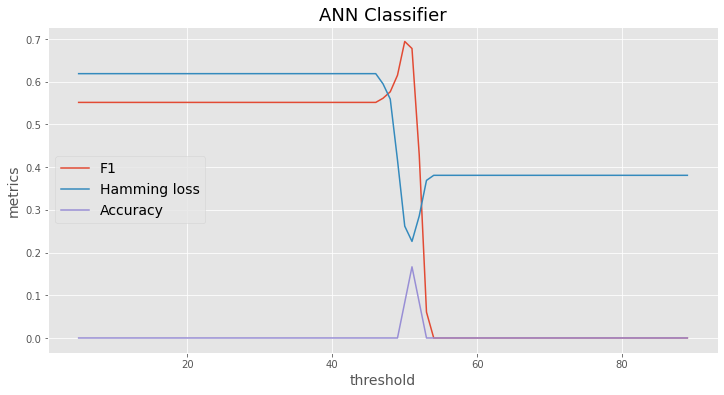

In [121]:
# print(history)
# results
# nn_predictions
plotting_metrics_function_of_threshold('ANN Classifier', nn_predictions, y_test)


In [136]:
pd_pred_prob = pd.DataFrame(nn_predictions, columns = tweets.columns.values[1:])
pd_pred = (pd_pred_prob.copy() >= 0.5)
pd_pred = pd_pred.where(pd_pred == True, 0)
pd_pred = pd_pred.where(pd_pred == False, 1)
pd_pred.insert(0, 'tweet', test_text)
pd_pred

,tweet,circumstantial-information,electricity,gas,gasoline,social-report,twitter-account,water
0,@corpoeleczulia_ dios mioo que pasa sigue...,1,1,0,1,0,0,0
1,15 horas #sinluz y de paso sin gas y...,1,1,0,1,0,0,0
2,20 horas #sinluz\n,1,1,0,0,1,0,1
3,buenas tardes @corpoelecinfo se mantiene ...,1,1,0,1,0,0,0
4,#sinluz valle de la pascua desde las 7 ...,1,1,0,0,0,0,0
5,que gran invento el celular #sinluz\n,1,1,0,0,1,0,1
6,@vpitv @mariacquintero san francisco #sinl...,1,1,0,0,0,0,1
7,#sinluz #lacabagna #laboyera #elhatillo @e...,1,0,0,1,0,0,1
8,en walker martinez con tobalaba la flo...,1,1,0,0,1,0,1
9,@luisgonzaloprz #sinluz desde el estado l...,1,1,0,0,0,0,0


In [137]:
tw_doc = 'La cosa esta dificil con lo de la luz y todo lo demas'
tw_doc_vector = vectorizer.transform([tw_doc])

tw_pred = model.predict([tw_doc_vector])
print('Prediction: \n', tw_doc)
pd.DataFrame(tw_pred, columns = tweets.columns.values[1:])

Prediction: 
 La cosa esta dificil con lo de la luz y todo lo demas


,circumstantial-information,electricity,gas,gasoline,social-report,twitter-account,water
0,0.521776,0.510997,0.498338,0.490496,0.520024,0.460011,0.506113


#### using Word Embeddings

TBD

In [138]:
# binarized_tweet_labels

#  these are all the labels, for now I will select only one of them
#  and we will test the classification on a single label.

# print( TEXT_DESCRIPTION_COL )
# print( CIRCUMSTANTIAL_DESCRIPTION_COL )
# print( ELECTRICITY_DESCRIPTION_COL )
# print( GAS_DESCRIPTION_COL )
# print( GASOLINE_DESCRIPTION_COL )
# print( SOCIAL_DESCRIPTION_COL )
# print( ACCOUNT_DESCRIPTION_COL )
# print( WATER_DESCRIPTION_COL )

